## Imports and download

In [ ]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse


warnings.filterwarnings("ignore")

In [ ]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"punkris","key":"b0bff742fdc1924cfe1807a1b6c032ab"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json /root/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
%%capture
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

### Чтение и объединение данных

In [ ]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

In [ ]:
books = books.merge(ratings, on='ISBN')
books = books.merge(users, on='User-ID')
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN


In [ ]:
books = books[books['Book-Rating'] != 0]

In [ ]:
books.shape

(383842, 12)

Идеи:

* Сгруппировать книги по ISBN и добавить параметр оценивающий книгу(средняя оценка книги, популярность)
* Сгруппировать пользователей. Сделать параметр базированности пользователя

## Приведём ISBN к численным значениям

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
books["ISBN"] = le.fit_transform(books["ISBN"])

books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
1,39,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
9,86701,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,8,5,"timmins, ontario, canada",NaN
12,110865,The Middle Stories,Sheila Heti,2004,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,8,5,"timmins, ontario, canada",NaN
13,119541,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,8,5,"timmins, ontario, canada",NaN
15,123999,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,http://images.amazon.com/images/P/1567407781.0...,http://images.amazon.com/images/P/1567407781.0...,http://images.amazon.com/images/P/1567407781.0...,8,6,"timmins, ontario, canada",NaN


## Train Test Split

In [ ]:
df_train, df_test = train_test_split(books, train_size=0.8)

## Преобразование данных

### Преобразуем location

#### Получим и проверим значения стран

In [ ]:
countries = df_train['Location'].str.split(', ', expand=True)[2]
countries_count = countries.value_counts()

In [ ]:
print(f'Всего стран: {len(countries_count)}')

Всего стран: 313


In [ ]:
def get_deleted_data(series, counts):
  series_count = series.value_counts()
  all_values = len(series_count)
  arr_remained_values = []
  arr_deleted_in_df_fraction = []
  for count in counts:
    del_values = series_count[series_count <= count].index

    remained_values = all_values - len(del_values)
    arr_remained_values.append(remained_values)

    deleted_in_df_fraction =  series.isin(del_values).mean()
    arr_deleted_in_df_fraction.append(deleted_in_df_fraction)
  return arr_remained_values, arr_deleted_in_df_fraction


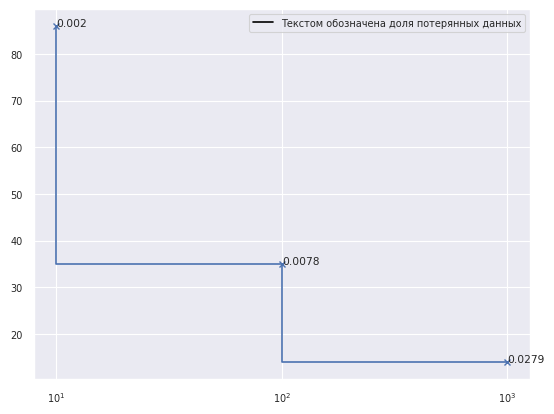

In [ ]:
value_counts = [10, 100, 1000]
remained, deleted_fraction = get_deleted_data(countries, value_counts)
plt.xscale('log')
plt.plot(value_counts, remained, drawstyle='steps', marker='x')
for x, y, text in zip(value_counts, remained, deleted_fraction):
  text = round(text, 4)
  text_data = plt.annotate(text, (x, y))
plt.plot([], [], '', color='black', label='Текстом обозначена доля потерянных данных')
plt.legend()

Видим, что можем удалить страны с меньше чем 100 отзывами на книги, потому что мы отсеем много лишних стран, но потеряем всего 0.0035 данных

Посмотрим на страны с количеством отзывово > 100, чтобы убрать ошибочные

In [ ]:
countries_count[countries_count > 100]

usa                   209769
canada                 28316
united kingdom         11562
germany                 9699
spain                   5674
australia               5588
n/a                     5531
france                  3699
portugal                2788
malaysia                1731
netherlands             1527
switzerland             1521
new zealand             1424
italy                   1228
austria                  850
singapore                595
philippines              433
romania                  369
brazil                   352
iran                     345
ireland                  342
dominican republic       311
sweden                   278
england                  275
finland                  274
belgium                  272
japan                    261
china                    255
norway                   213
argentina                148
mexico                   144
poland                   131
denmark                  113
new york                 109
israel        

Видим плохие данные:
n/a, far away..., universe

Несколько вариантов названий Америки:us, united states, united state

#### Изменение train и test

Добавим countries в train и test

In [ ]:
for df in df_train, df_test:
  df['countries'] = df['Location'].str.split(', ', expand=True)[2]

Заменим данные на nan

In [ ]:
remained_countries = set(countries_count[countries_count > 100].index)
remained_countries = remained_countries.difference(['n/a', 'far away...', 'universe'])

def replace_func(x):
  if x in remained_countries:
    return x
  else:
    return np.nan

df_train['countries'] = df_train['countries'].apply(replace_func)
df_test['countries'] = df_test['countries'].apply(replace_func)

In [ ]:
replace_counties = {distorted: 'usa' for distorted in ['us', 'united states', 'united state', 'new york']}
replace_counties['england'] = 'united kingdom'
for df in df_train, df_test:
  df['countries'].replace(replace_counties, inplace=True)

Посмотрим сколько na

In [ ]:
print(f'Доля na в countrie: {df_train["countries"].isna().mean():.2f}')

Доля na в countrie: 0.05


Доля na очень низкая. Заменим na самым популярным значением

In [ ]:
most_freq = df_train['countries'].mode().iloc[0]
for df in [df_train, df_test]:
  df['countries'].fillna(most_freq, inplace=True)

One hot encoding применим далее

### Преобразуем Age

Удалим возраст меньше 0 и больше 100

In [ ]:
replace_func = lambda x: np.nan if (x <= 0 or x >= 100) else x

for df in [df_train, df_test]:
  df['Age'] = df['Age'].apply(replace_func)

#### Определимся с na

In [ ]:
print(f'Доля na в Age: {df_train["Age"].isna().mean():.2f}')

Доля na в Age: 0.30


1/4 данных отсутствует. Посмотрим на распределение возраста

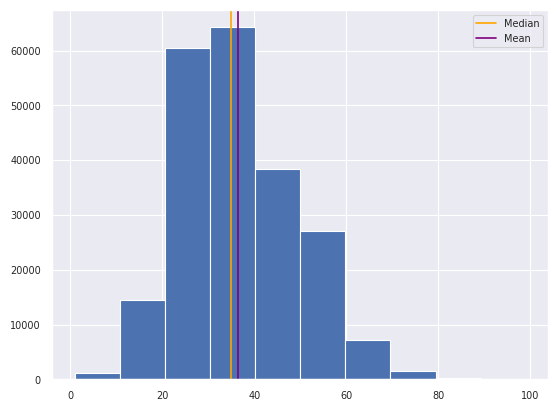

In [ ]:
plt.hist(df_train['Age'])
plt.axvline(df_train['Age'].median(), c='orange', label='Median')
plt.axvline(df_train['Age'].mean(), c='purple', label='Mean')
plt.legend();

Видим, что распределение похоже на нормальное и медиана очень близко к среднем => можем заменить na на среднее

In [ ]:
mean = df_train['Age'].mean()
for df in [df_train, df_test]:
  df['Age'].fillna(mean, inplace=True)

### Преобразуем Year of publication

Преобразуем в целое число

In [ ]:
for df in [df_train, df_test]:
  del_year_mask = df['Year-Of-Publication'].isin(['Gallimard', 'DK Publishing Inc'])
  del_indexes = df[del_year_mask].index
  df.drop(del_indexes, inplace=True)
  df['Year-Of-Publication'] = df['Year-Of-Publication'].astype(int)

(array([4.64200e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 3.02428e+05]),
 array([   0.,  205.,  410.,  615.,  820., 1025., 1230., 1435., 1640.,
        1845., 2050.]),
 <BarContainer object of 10 artists>)

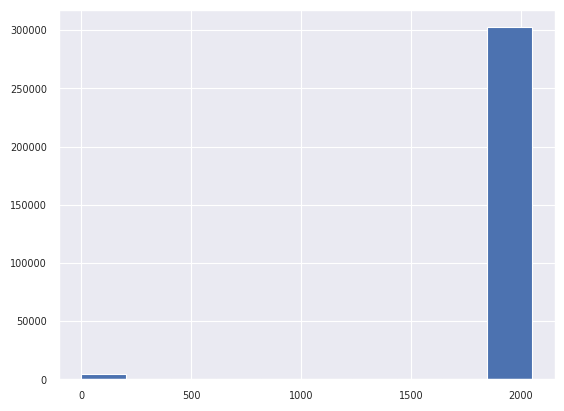

In [ ]:
plt.hist(df_train['Year-Of-Publication'])

Здесь присутствуют книги с 0-м годом публикации. Технически такие данные не являются ошибкой, но они могут негативно повлиять на работу алгоритмов МО

С логической точки зрения Года 1400 и 1500 не сильно отличаются, но 1900 и 2000 сильно, поэтому логичнее превратить год публикации в категориальную переменную


### Заменим год публикации на категориальные данные

In [ ]:
df_train['Year-Of-Publication']

676671    2000
819812    1992
365902    2000
1899      2002
604420    1987
          ... 
298531    2003
587562    1994
954892    1990
593778    2001
959128    2001
Name: Year-Of-Publication, Length: 307072, dtype: int64

In [ ]:
def replace_func(x):
  if x >= 2010:
    return '2010'
  elif x>= 2000:
    return '2000'
  elif x >= 1980:
    return '1980'
  elif x>=1950:
    return '1950'
  elif x>= 1900:
    return '1900'
  elif x>=1500:
    return '1500'
  else:
    return '0'

for df in [df_train, df_test]:
  df['Year-Of-Publication'] = df['Year-Of-Publication'].apply(replace_func)

<Axes: xlabel='Year-Of-Publication', ylabel='count'>

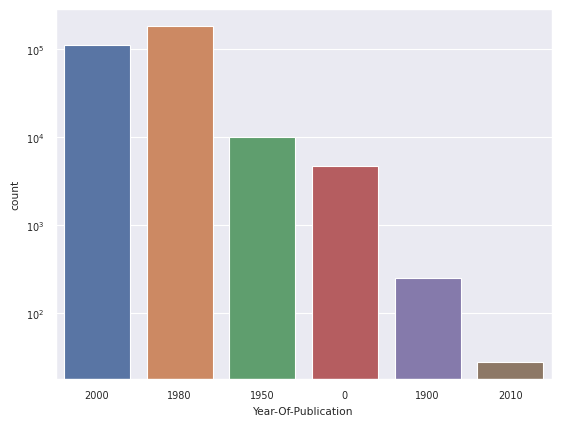

In [ ]:
plt.yscale('log')
sns.countplot(data=df_train, x='Year-Of-Publication')

#### Посчитаем None

In [ ]:
print(f"Доля na в годе издания:{df_train['Year-Of-Publication'].isna().mean():.2f}")

Доля na в годе издания:0.00


### Publisher

Если мы удалим все издания меньше чем со 100 отзывами, то сколько данных мы потеряем?

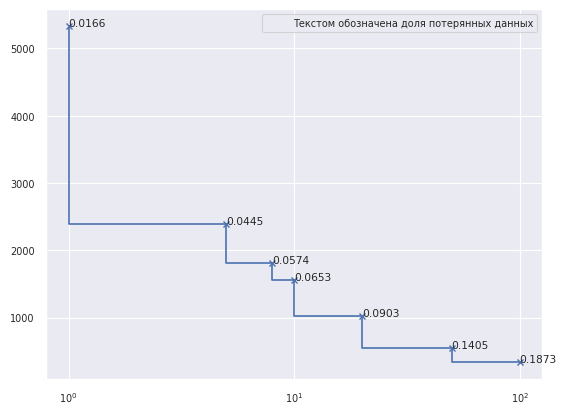

In [ ]:
value_counts = [1, 5, 8, 10, 20, 50, 100]
remained, deleted_fraction = get_deleted_data(df_train['Publisher'], value_counts)
plt.xscale('log')
plt.plot(value_counts, remained, drawstyle='steps', marker='x')
for x, y, text in zip(value_counts, remained, deleted_fraction):
  text = round(text, 4)
  text_data = plt.annotate(text, (x, y))
plt.plot([], [], ' ', label='Текстом обозначена доля потерянных данных')
plt.legend()

Видим, что несмотря на уменьшение до 3000 при потере в 3% мы не сможем применить OneHotEncoding к издательству, поэтому логичнее всего будет не удалять издательства, а применить TF-IDF

### Заменим nan

Посмотрим количество NA

In [ ]:
print(f'Количество na в publisher: {df_train["Publisher"].isna().sum()}')

Количество na в publisher: 2


Удалим строки с na

In [ ]:
for df in [df_train, df_test]:
  del_rows = df[df['Publisher'].isna()].index
  df.drop(del_rows, inplace=True)

### Добваим столбец со средним возрастом, людей оставивших отзыв

In [ ]:
isbn_mean_age_train = df_train.groupby('ISBN')['Age'].mean().reset_index(name='mean_age')

df_train = df_train.reset_index().merge(isbn_mean_age_train, on='ISBN', how='left').set_index('index')

df_test = df_test.reset_index().merge(isbn_mean_age_train, on='ISBN', how='left').set_index('index')

Для тех, что не попали в df_train посчитаем среднее из test

In [ ]:
isbn_mean_age_test = df_test.groupby('ISBN')['Age'].mean().reset_index(name='mean_age_test')
df_test = df_test.reset_index().merge(isbn_mean_age_test, on='ISBN', how='left').set_index('index')

df_test['mean_age'].fillna(df_test['mean_age_test'], inplace=True)
df_test.drop(['mean_age_test'], axis=1, inplace=True)

In [ ]:
df_train.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,countries,mean_age
index,,,,,,,,,,,,,,
676671,60046,Heart of the Sea (Irish Trilogy),Nora Roberts,2000,Jove Books,http://images.amazon.com/images/P/0515128554.0...,http://images.amazon.com/images/P/0515128554.0...,http://images.amazon.com/images/P/0515128554.0...,243720,8,"hickory, north carolina, usa",36.558352,usa,36.917013
819812,72235,The Dark Half,Stephen King,1980,Viking Books,http://images.amazon.com/images/P/067082982X.0...,http://images.amazon.com/images/P/067082982X.0...,http://images.amazon.com/images/P/067082982X.0...,98596,9,"dallas, texas, usa",34.000000,usa,37.373536
365902,35796,Cryptonomicon,Neal Stephenson,2000,Perennial,http://images.amazon.com/images/P/0380788624.0...,http://images.amazon.com/images/P/0380788624.0...,http://images.amazon.com/images/P/0380788624.0...,250153,8,"kingston, ontario, canada",32.000000,canada,37.624078
1899,81868,Grave Secrets (Temperance Brennan Novel (Hardc...,Kathy Reichs,2000,Scribner,http://images.amazon.com/images/P/0684859734.0...,http://images.amazon.com/images/P/0684859734.0...,http://images.amazon.com/images/P/0684859734.0...,11676,10,"n/a, n/a, n/a",36.558352,usa,39.992959
604420,32049,"Toughing It Out (Crosswinds, No 3)",Joan Oppenheimer,1980,Harlequin,http://images.amazon.com/images/P/0373980035.0...,http://images.amazon.com/images/P/0373980035.0...,http://images.amazon.com/images/P/0373980035.0...,191883,10,"mount airy, north carolina, usa",27.000000,usa,27.000000


In [ ]:
df_test.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,countries,mean_age
index,,,,,,,,,,,,,,
1012836,145246,Segunda Fundacion/Second Foundation,Isaac Asimov,1980,"Bruguera, S.A.",http://images.amazon.com/images/P/8402048323.0...,http://images.amazon.com/images/P/8402048323.0...,http://images.amazon.com/images/P/8402048323.0...,265051,7,"palma de mallorca, islas baleares, spain",40.000000,spain,40.000000
791853,63174,The Rana Look,SANDRA BROWN,2000,Bantam,http://images.amazon.com/images/P/0553104241.0...,http://images.amazon.com/images/P/0553104241.0...,http://images.amazon.com/images/P/0553104241.0...,107865,8,"tampa, florida, usa",36.558352,usa,42.519451
84530,55931,Dead of Night: The True Story of a Serial Kill...,Don Lasseter,1980,Onyx Books,http://images.amazon.com/images/P/0451407032.0...,http://images.amazon.com/images/P/0451407032.0...,http://images.amazon.com/images/P/0451407032.0...,123981,7,"phoenix, arizona, usa",46.000000,usa,48.000000
598531,43362,The Secret Diary of Adrian Mole Aged 13 3/4,Sue Townsend,1980,Methuen Publishing Ltd,http://images.amazon.com/images/P/0413537900.0...,http://images.amazon.com/images/P/0413537900.0...,http://images.amazon.com/images/P/0413537900.0...,225232,8,"sydney, new south wales, australia",4.000000,australia,33.657248
464288,27758,"Chase The Dawn (Harlequin Presents, 1196)",John N. Walker,1980,Harlequin,http://images.amazon.com/images/P/0373111967.0...,http://images.amazon.com/images/P/0373111967.0...,http://images.amazon.com/images/P/0373111967.0...,25981,5,"nj, new jersey, usa",36.558352,usa,36.558352


### na в текстовых столбцах

In [ ]:
df_train.name = 'train'
df_test.name = 'test'
for df in [df_train, df_test]:
  print(df.name)
  for col in ['Book-Title', 'Book-Author', 'Publisher']:
    print(f"\t{col}: {df[col].isna().sum()}")

train
	Book-Title: 0
	Book-Author: 1
	Publisher: 0
test
	Book-Title: 0
	Book-Author: 0
	Publisher: 0


In [ ]:
df_train.dropna(axis=0, inplace=True)

In [ ]:
for df in df_train, df_test:
  print(f'{df.name} na:')
  display(df.isna().sum())

train na:


ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
User-ID                0
Book-Rating            0
Location               0
Age                    0
countries              0
mean_age               0
dtype: int64

test na:


ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
User-ID                0
Book-Rating            0
Location               0
Age                    0
countries              0
mean_age               0
dtype: int64

### Удалим столбцы

In [ ]:
delete_cols = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Location']

In [ ]:
for df in [df_train, df_test]:
  df.drop(delete_cols, axis=1, inplace=True)

In [ ]:
df_train.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,countries,mean_age
index,,,,,,,,,,
676671,60046,Heart of the Sea (Irish Trilogy),Nora Roberts,2000,Jove Books,243720,8,36.558352,usa,36.917013
819812,72235,The Dark Half,Stephen King,1980,Viking Books,98596,9,34.000000,usa,37.373536
365902,35796,Cryptonomicon,Neal Stephenson,2000,Perennial,250153,8,32.000000,canada,37.624078
1899,81868,Grave Secrets (Temperance Brennan Novel (Hardc...,Kathy Reichs,2000,Scribner,11676,10,36.558352,usa,39.992959
604420,32049,"Toughing It Out (Crosswinds, No 3)",Joan Oppenheimer,1980,Harlequin,191883,10,27.000000,usa,27.000000


## Разбиваем страны по популярности

In [ ]:
counties_counts = df_train['countries'].value_counts()

In [ ]:
sns.set_context('paper', font_scale=0.8)

<Axes: xlabel='count', ylabel='countries'>

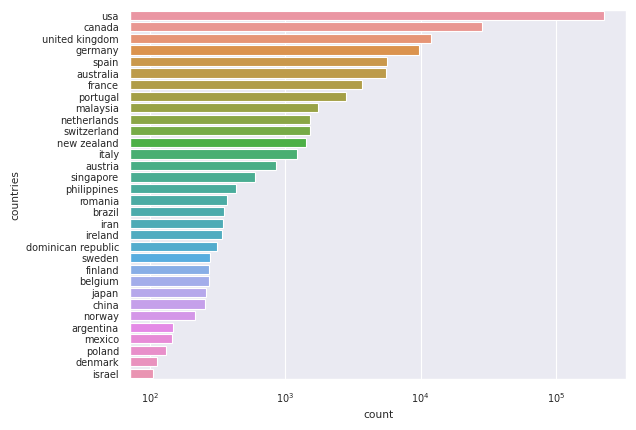

In [ ]:
plt.xscale('log')
sns.countplot(data=df_train, y='countries', order=counties_counts.index)

In [ ]:
counties_lvl = np.log10(counties_counts).astype(int).to_frame('country_lvl')
counties_lvl.head()

,country_lvl
usa,5
canada,4
united kingdom,4
germany,3
spain,3


In [ ]:
df_train = df_train.merge(counties_lvl, left_on='countries', right_index=True, how='left')
df_test = df_test.merge(counties_lvl, left_on='countries', right_index=True, how='left')
df_train.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,countries,mean_age,country_lvl
index,,,,,,,,,,,
676671,60046,Heart of the Sea (Irish Trilogy),Nora Roberts,2000,Jove Books,243720,8,36.558352,usa,36.917013,5
819812,72235,The Dark Half,Stephen King,1980,Viking Books,98596,9,34.000000,usa,37.373536,5
365902,35796,Cryptonomicon,Neal Stephenson,2000,Perennial,250153,8,32.000000,canada,37.624078,4
1899,81868,Grave Secrets (Temperance Brennan Novel (Hardc...,Kathy Reichs,2000,Scribner,11676,10,36.558352,usa,39.992959,5
604420,32049,"Toughing It Out (Crosswinds, No 3)",Joan Oppenheimer,1980,Harlequin,191883,10,27.000000,usa,27.000000,5


## Работаем с категориальными данными и текстом

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import  Pipeline
from scipy import sparse


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Найдем стопслова для Publisher

Для этого посчитаем самые частовстречаемые слова

In [ ]:
punct = set(string.punctuation + "—" + "«" + "»")
eng_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def basic_tokenizer(inp_str):
  inp_str = inp_str.lower()
  tokenized = [token for token in word_tokenize(inp_str)
               if (token not in punct) and (token not in eng_stopwords)]
  return tokenized

In [ ]:
word_appearance = defaultdict(int)
for publisher in df_train['Publisher'].sample(100000):
  tokenized = basic_tokenizer(publisher)
  for word in set(tokenized):
    word_appearance[word] += 1

In [ ]:
word_appearance = pd.Series(word_appearance)
word_appearance.sort_values(ascending=False)

books         27484
publishing     7112
press          5557
bantam         4631
group          4435
              ...  
i.p.a.c.s         1
maryland          1
evergreen         1
wong              1
seabury           1
Length: 4967, dtype: int64

In [ ]:
additional_stopwords = {'books', 'publishing', 'group', 'press', 'company', "'s", 'house', 'book', 'pub', 'inc', 'ltd'}
publisher_stopwords = list(eng_stopwords.union(additional_stopwords))


### Book-Title Glove

In [ ]:
import gensim.downloader
vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [ ]:
vectors['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [ ]:
print("Num words:", len(vectors))

Num words: 400000


In [ ]:
def get_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [ ]:
get_dist(vectors['king'], vectors['queen'])

3.477756

In [ ]:
get_dist(vectors['apple'], vectors['rocket'])

7.0061626

In [ ]:
class GensimTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.vectors = vectors
    self.vector_size = self.vectors.vector_size

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    res_matrix = np.zeros([len(X), self.vector_size])
    for row, inp_str in enumerate(X):
      tokenized = basic_tokenizer(inp_str)
      vectorized_tokens = 1
      for token in tokenized:
        if token in self.vectors:
          vector = self.vectors[token]
          res_matrix[row] += vector
          vectorized_tokens += 1
      res_matrix[row] /= vectorized_tokens
    return res_matrix

g = GensimTransformer()
trasform_res = g.fit_transform(df_train['Book-Title'].iloc[:1000])


## Напишем трансформер для всех столбцов

In [ ]:
scaler_transformer = ColumnTransformer(
    [
        ('scaler',  StandardScaler(), ['Age', 'mean_age'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

scaler_transformer.set_output(transform='pandas')

text_transformer = ColumnTransformer([
#        ('glove', GensimTransformer(), 'Book-Title'),
#        ('tf-idf',TfidfVectorizer(max_features=3000, stop_words=publisher_stopwords), 'Publisher'),
#        ('bag_of_words', CountVectorizer(max_features=3000), 'Book-Author'),
        ('onehot', OneHotEncoder(), ['countries', 'Year-Of-Publication'])
    ],
    remainder='passthrough'
)

normalizer = Normalizer()

pipline = Pipeline([
    ('scaler', scaler_transformer),
    ('text_transformer',  text_transformer),
#    ('normalizer', normalizer)
])

In [ ]:
def get_transform_data(X, y, fit: bool = True, save_as: str = None):
    if fit:
        X = pipline.fit_transform(X)
    else:
        X = pipline.transform(X)

    if save_as:
        sparse.save_npz(f"X_{save_as}.npz", X)
        y.to_csv(f'y_{save_as}.csv')

    return X

In [ ]:
def split_X_y(df):
  return df.drop('Book-Rating', axis=1), df[['Book-Rating']]


not_used = ['ISBN', 'User-ID', 'Book-Title', 'Publisher', 'Book-Author']

X_train, y_train = split_X_y(df_train.drop(not_used, axis=1))
X_test, y_test = split_X_y(df_test.drop(not_used, axis=1))

In [ ]:
X_train_transformed = get_transform_data(X_train, y_train, save_as='train')
X_test_transformed = get_transform_data(X_test, y_test, fit=False, save_as='test')

ValueError: ignored

In [ ]:
X_train_nozero_df, y_train_nozero_df = split_X_y(df_train[df_train['Book-Rating'] > 0].drop(not_used, axis=1))
X_test_nozero_df, y_test_nozero_df = split_X_y(df_test[df_test['Book-Rating'] > 0].drop(not_used, axis=1))

In [ ]:
# У нас 1 запись с 1500 Year-Of-Publication и если она попадает в test получаем проблемы

y_test_nozero_df = y_test_nozero_df[X_test_nozero_df['Year-Of-Publication'] != '1500']
X_test_nozero_df = X_test_nozero_df[X_test_nozero_df['Year-Of-Publication'] != '1500']

In [ ]:
X_train_nozero = get_transform_data(X_train_nozero_df, y_train_nozero_df, save_as='train_nozero')
X_test_nozero = get_transform_data(X_test_nozero_df, y_test_nozero_df, fit=False, save_as='test_nozero')

Скачиваем матрицу

## imports and helper functions

In [197]:
import random
random.seed(36)

import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import sparse
from time import time
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score


warnings.filterwarnings("ignore")

In [198]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/data/PDA/lab1/

Mounted at /content/drive
/content/drive/My Drive/data/PDA/lab1


In [199]:
!ls

book-recommendation-dataset.zip  X_test_transformed_nozero.npz	 y_test_nozero.csv
Books.csv			 X_test_transformed.npz		 y_train.csv
Ratings.csv			 X_train_transformed_nozero.npz  y_train_nozero.csv
recsys_taxonomy2.png		 X_train_transformed.npz
Users.csv			 y_test.csv


In [204]:
def get_data(no_zero=False):
  if not no_zero:
    X_train = sparse.load_npz("X_train_transformed.npz")
    X_test =  sparse.load_npz("X_test_transformed.npz")
    y_train = pd.read_csv('y_train.csv', index_col='index')
    y_test = pd.read_csv('y_test.csv', index_col='index')
  else:
    X_train = sparse.load_npz("X_train_transformed_nozero.npz")
    X_test =  sparse.load_npz("X_test_transformed_nozero.npz")
    y_train = pd.read_csv('y_train_nozero.csv', index_col='index')
    y_test = pd.read_csv('y_test_nozero.csv', index_col='index')
  return X_train, X_test, y_train, y_test

# Linear Regression

In [205]:
X_train_transformed, X_test_transformed, y_train, y_test = get_data()

In [206]:
t = time()

lr = LinearRegression()
lr.fit(X_train_transformed, y_train)

print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to fit the model: 5.88 mins


In [ ]:
predictions = lr.predict(X_test_transformed)

In [ ]:
pred = pd.DataFrame({'Actual': y_test['Book-Rating'], 'Predicted': [int(a[0]) for a in predictions.tolist()]}).head(25)
pred.head(10)

,Actual,Predicted
index,,
914502,0,2
52551,0,2
335373,6,2
701031,10,2
829820,0,2
926349,9,2
514714,0,2
233015,9,2
301687,0,2


<Axes: xlabel='index'>

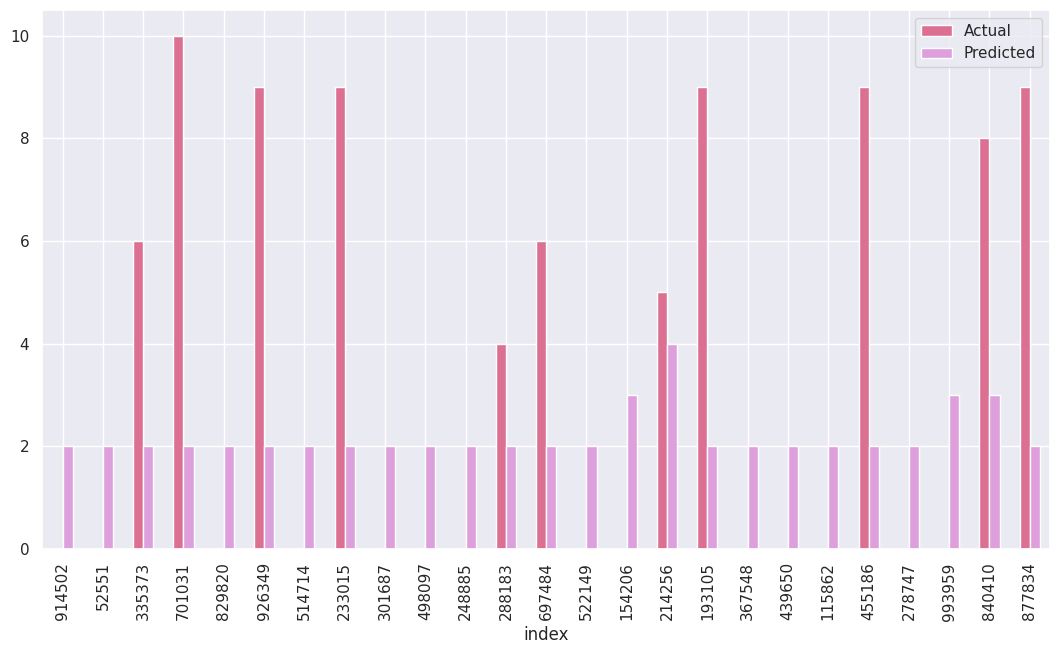

In [ ]:
pred.plot(kind='bar', figsize=(13, 7), color=['palevioletred', 'plum'])

выглядит грустно... 😞

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.54941233231352
MSE: 14.784617504811342
RMSE: 3.845077047968134


<Axes: >

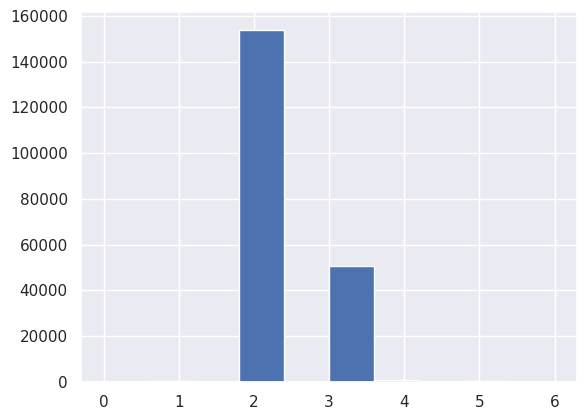

In [ ]:
#pd.Series(predictions[:, 0]).astype(int).hist()

# Linear Regression, но без нулевых отзывов

А посмотрим на распределение таргета....

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

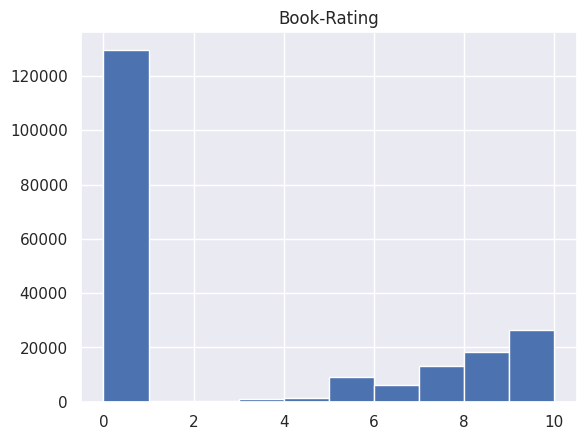

In [ ]:
y_test.hist()

Оно приводит к скошенным в меньшую сторону результатам модели :( Особенно учитывая, что это не валидная оценка

In [ ]:
X_train_nozero, X_test_nozero, y_train_nozero, y_test_nozero = get_data(no_zero=True)

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

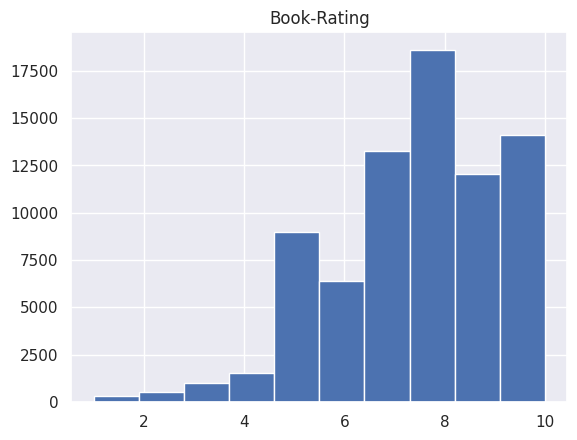

In [ ]:
y_test_nozero.hist()
# Распределение здорового человека. Kind of...

In [ ]:
t = time()

lr_nozero = LinearRegression()
lr_nozero.fit(X_train_nozero, y_train_nozero)

print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to fit the model: 0.02 mins


<Axes: xlabel='index'>

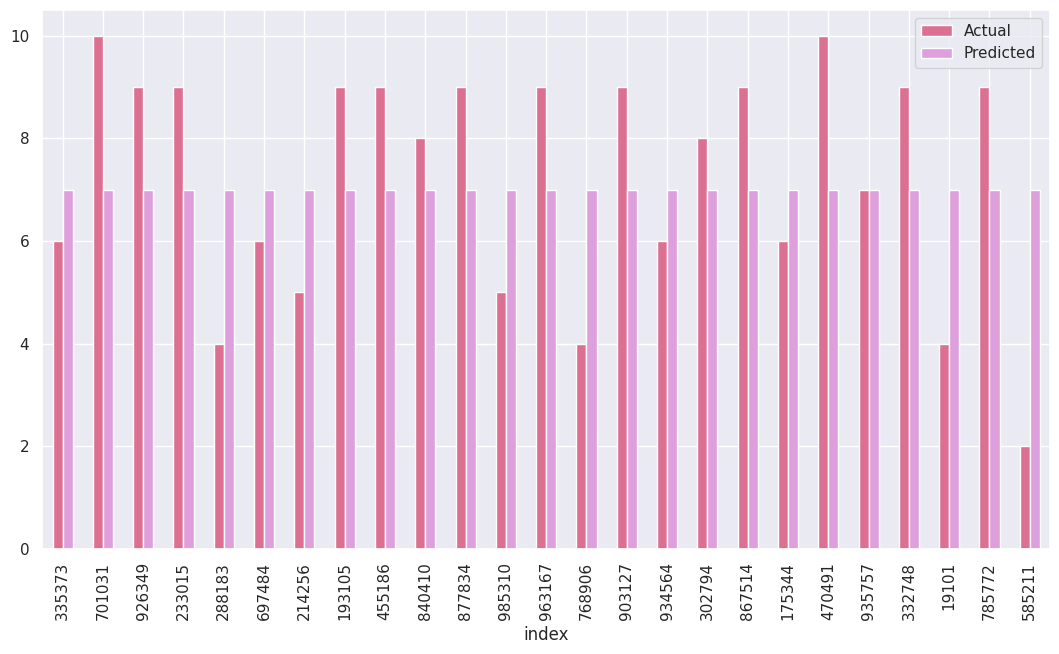

In [ ]:
predictions = lr_nozero.predict(X_test_nozero)
pred = pd.DataFrame({'Actual': y_test_nozero['Book-Rating'], 'Predicted': [int(a[0]) for a in predictions.tolist()]}).head(25)
pred.plot(kind='bar', figsize=(13, 7), color=['palevioletred', 'plum'])

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_nozero, predictions))
print('MSE:', metrics.mean_squared_error(y_test_nozero, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_nozero, predictions)))

MAE: 1.493556685000281
MSE: 3.3985124026142532
RMSE: 1.84350546584876


# Random forest, with zeros

В коллабе очень долго, делаю локально

In [ ]:
X_train_transformed, X_test_transformed, y_train, y_test = get_data()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

t = time()

rfc = RandomForestClassifier(verbose=2, n_estimators=4, n_jobs=-1)
rfc.fit(X_train_transformed, y_train)

display(rfc.score(X_train_transformed, y_train))

print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    8.4s finished


0.7187011305585391

Time to fit the model: 10.8 mins


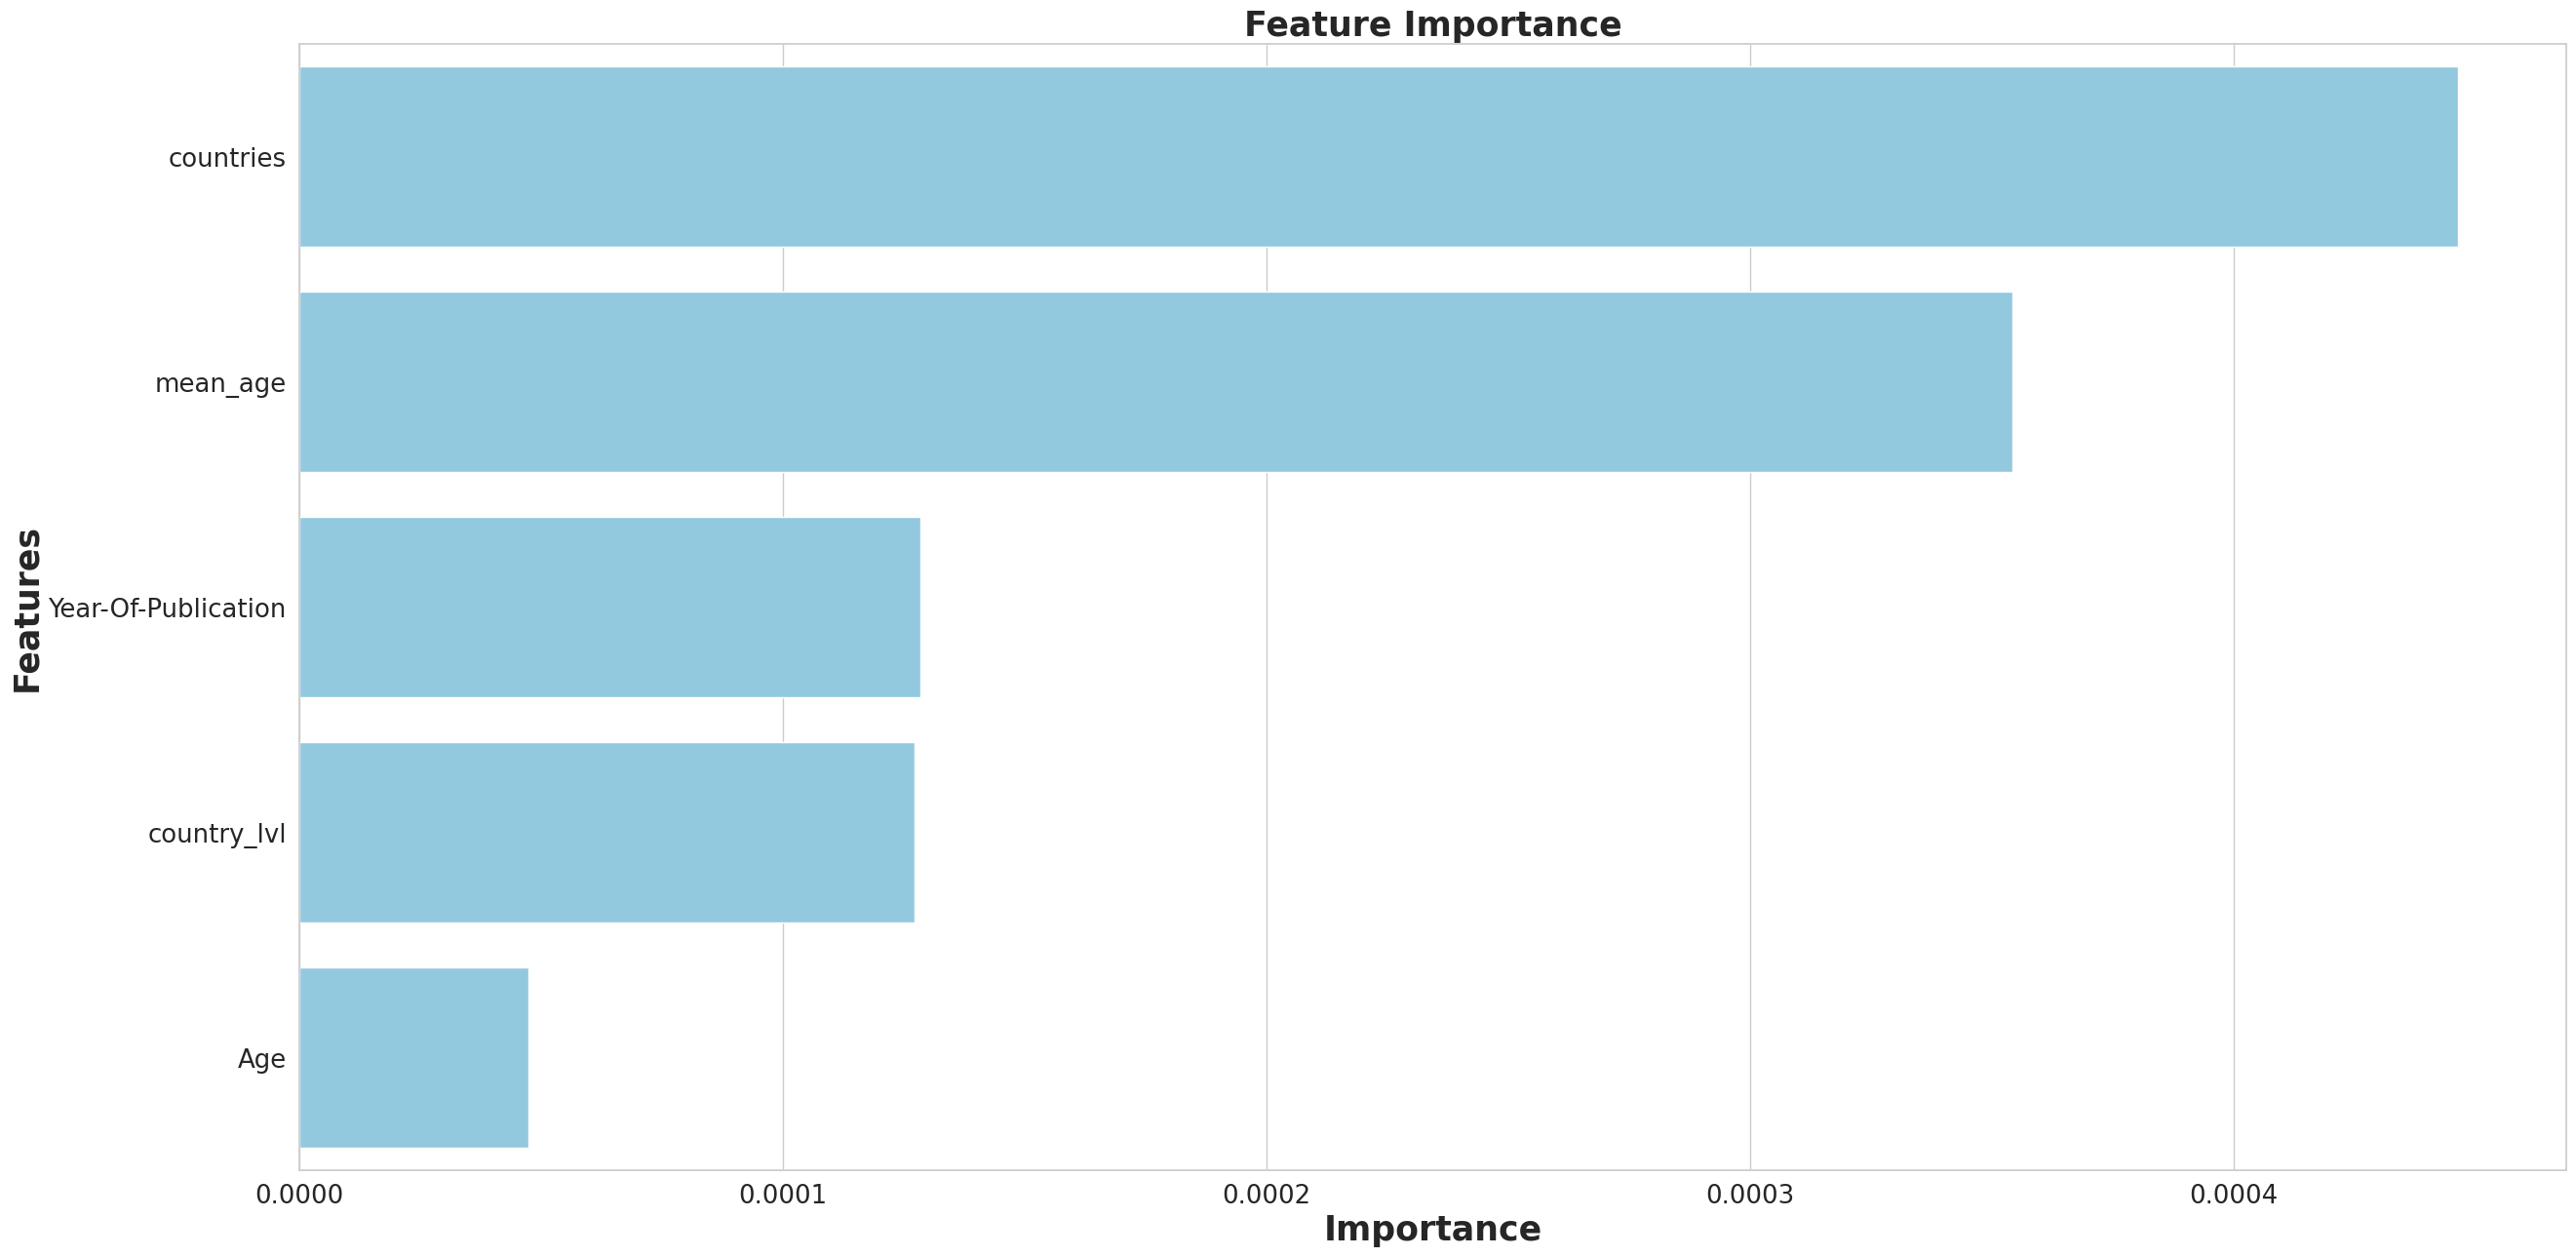

None

,Features,Gini-Importance
0,countries,0.000447
1,mean_age,0.000354
2,Year-Of-Publication,0.000128
3,country_lvl,0.000127
4,Age,0.000047


In [ ]:
feats = {}
for feature, importance in zip(X_train.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.6s finished


<Axes: xlabel='index'>

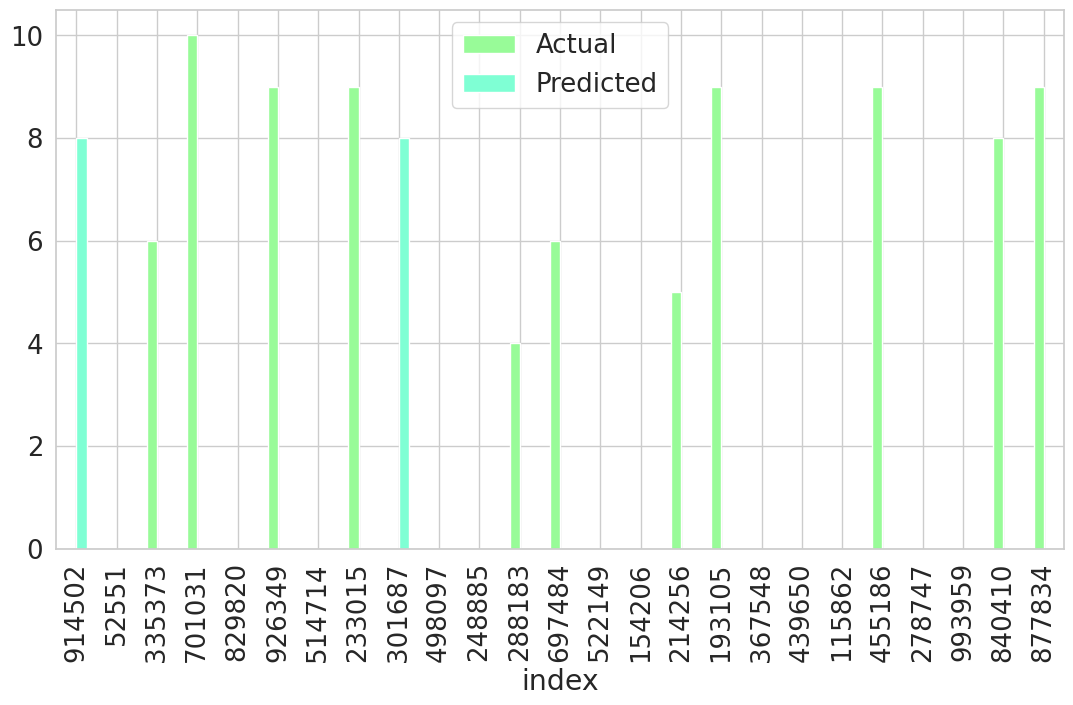

In [ ]:
predictions = rfc.predict(X_test_transformed)
pred = pd.DataFrame({'Actual': y_test['Book-Rating'], 'Predicted': [int(a) for a in predictions.tolist()]}).head(25)
pred.plot(kind='bar', figsize=(13, 7), color=['palegreen', 'aquamarine'])

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.209229590550265
MSE: 25.17042787594313
RMSE: 5.017013840517397


# Random Forest, no zeros

In [ ]:
X_train_nozero, X_test_nozero, y_train_nozero, y_test_nozero = get_data(no_zero=True)

In [ ]:
t = time()

rfc_nozero = RandomForestClassifier(verbose=2, n_estimators=4, n_jobs=2)
rfc_nozero.fit(X_train_nozero, y_train_nozero)

display(rfc_nozero.score(X_train_nozero, y_train_nozero))

print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.0s finished


0.5841743769112776

Time to fit the model: 2.95 mins


Посмотрим насколько важными модель посчитала наши признаки:

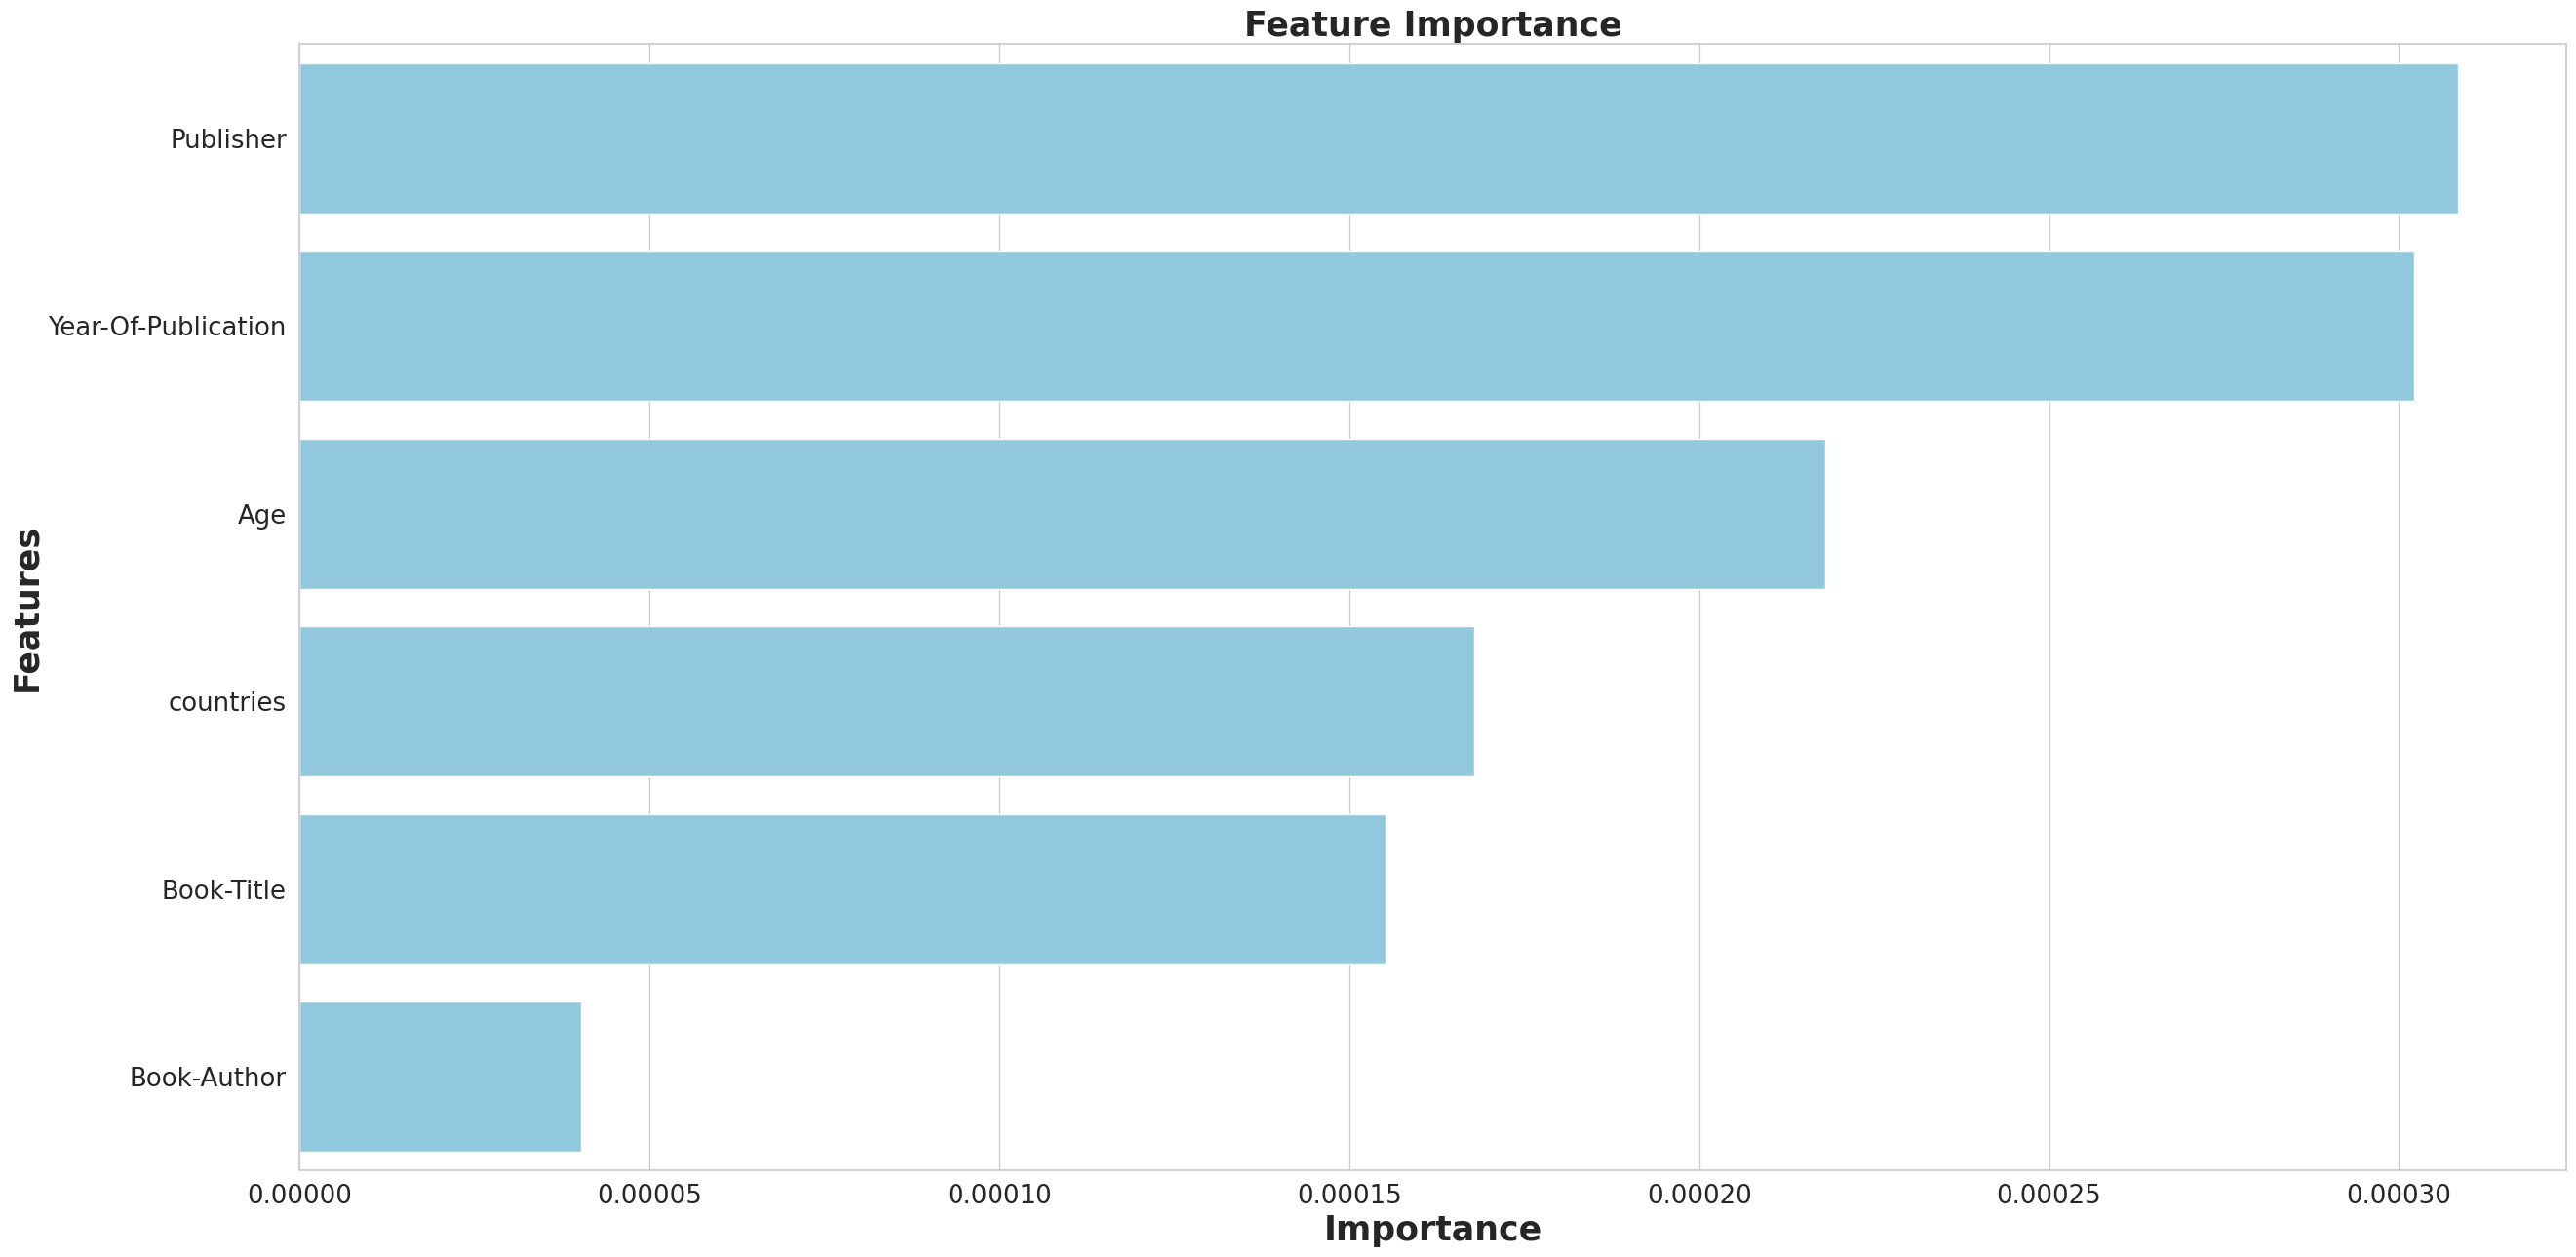

None

,Features,Gini-Importance
0,Publisher,0.000308
1,Year-Of-Publication,0.000302
2,Age,0.000218
3,countries,0.000168
4,Book-Title,0.000155
5,Book-Author,0.000040


In [ ]:
feats = {}
for feature, importance in zip(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Age',
       'countries'], rfc_nozero.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.3s finished


<Axes: xlabel='index'>

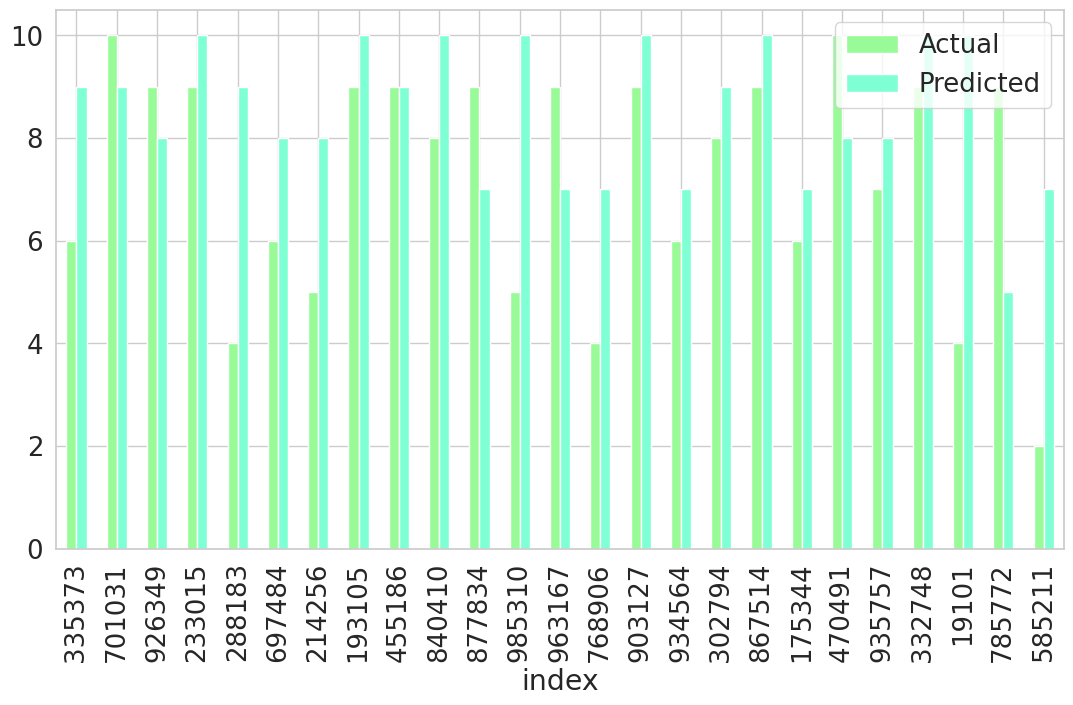

In [ ]:
predictions = rfc_nozero.predict(X_test_nozero)

pred = pd.DataFrame({'Actual': y_test_nozero['Book-Rating'], 'Predicted': [int(a) for a in predictions.tolist()]}).head(25)
pred.plot(kind='bar', figsize=(13, 7), color=['palegreen', 'aquamarine'])

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_nozero, predictions))
print('MSE:', metrics.mean_squared_error(y_test_nozero, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_nozero, predictions)))

MAE: 1.8838890336025007
MSE: 6.12387340453243
RMSE: 2.4746461170301566


посчитаю локально)

# XGBOOST, with zeros

In [ ]:
import xgboost as xgb

X_train_transformed, X_test_transformed, y_train, y_test = get_data()

dtrain_reg = xgb.DMatrix(X_train_transformed, y_train)
dtest_reg = xgb.DMatrix(X_test_transformed, y_test)

Посмотрим линейную регрессию:

In [ ]:
params = {"objective": "reg:linear", "tree_method": "auto"}

n = 100
xgb_model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

<Axes: xlabel='index'>

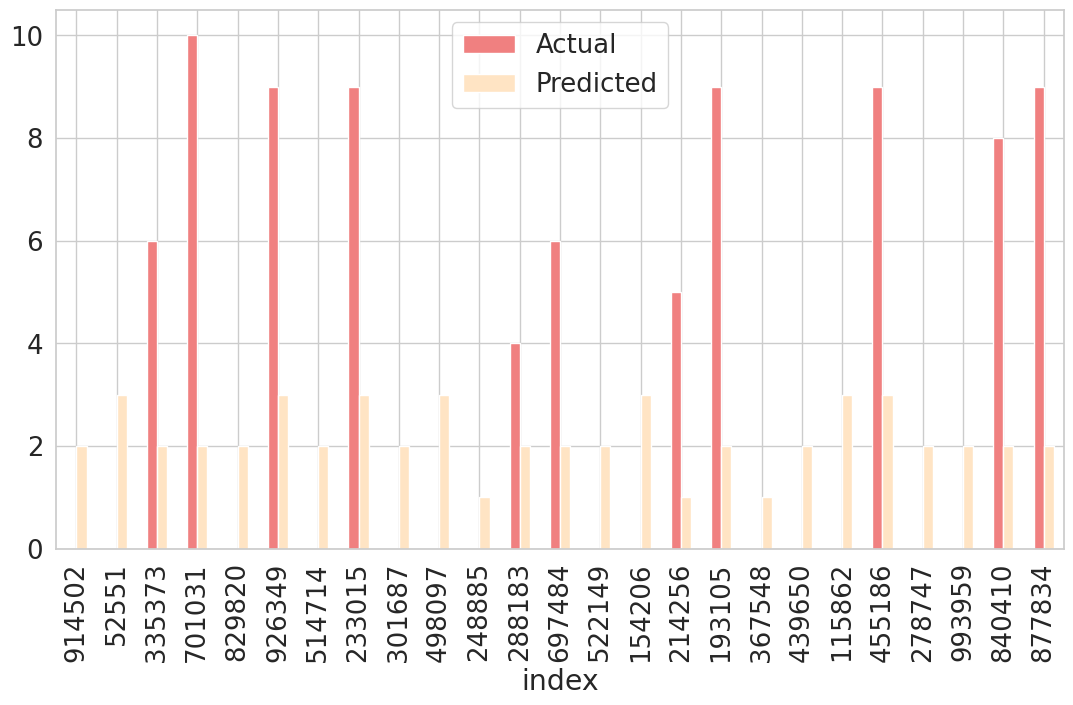

In [ ]:
predictions = xgb_model.predict(dtest_reg)
pred = pd.DataFrame({'Actual': y_test['Book-Rating'], 'Predicted': [int(a) for a in predictions.tolist()]}).head(25)
pred.plot(kind='bar', figsize=(13, 7), color=['lightcoral', 'bisque'])


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.422066204365098
MSE: 14.25706513906168
RMSE: 3.7758529022012604


Получили что-то похожее на результаты выше. Проверим все регрессии в XGBOOST: (todo: проверить классификацию тоже)

In [ ]:
methods = {
 'reg:linear': {"objective": 'reg:linear', "tree_method": "auto"},
 'reg:pseudohubererror': {"objective": 'reg:pseudohubererror', "tree_method": "auto"},
 'reg:absoluteerror':  {"objective": 'reg:absoluteerror', "tree_method": "auto"},
 'reg:quantileerror':  {"objective": 'reg:quantileerror', "tree_method": "auto", 'quantile_alpha': 0.05},
 'reg:tweedie': {"objective": 'reg:tweedie', "tree_method": "auto"}}

best_xgb_model = None
best_xgb_model_mae = np.inf

for method in methods.keys():
    params = methods[method]
    n = 100

    t = time()

    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,
    )

    print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))

    predictions = xgb_model.predict(dtest_reg)
    mae = metrics.mean_absolute_error(y_test, predictions)

    print(f'method: {method}, scores:')
    print('MAE:', mae)
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print('\n')

    if mae < best_xgb_model_mae:
        best_xgb_model = xgb_model


Time to fit the model: 0.2 mins
method: reg:linear, scores:
MAE: 3.422066204365098
MSE: 14.25706513906168
RMSE: 3.7758529022012604


Time to fit the model: 0.39 mins
method: reg:pseudohubererror, scores:
MAE: 4.137927698309503
MSE: 532.4159453735366
RMSE: 23.07414018709119


Time to fit the model: 1.3 mins
method: reg:absoluteerror, scores:
MAE: 2.8023349000559206
MSE: 22.026618648583284
RMSE: 4.693252459497921


Time to fit the model: 0.74 mins
method: reg:quantileerror, scores:
MAE: 2.8408906647002796
MSE: 22.948247788839787
RMSE: 4.790432943778651


Time to fit the model: 0.57 mins
method: reg:tweedie, scores:
MAE: 3.4168490607673596
MSE: 14.281960193776943
RMSE: 3.7791480777785016




Результаты примерно такие же :(

# XGB no zero

In [ ]:
X_train_nozero, X_test_nozero, y_train_nozero, y_test_nozero = get_data(no_zero=True)
dtrain_reg_nozero = xgb.DMatrix(X_train_nozero, y_train_nozero)
dtest_reg_nozero = xgb.DMatrix(X_test_nozero, y_test_nozero)

In [ ]:
params = {"objective": "reg:linear", "tree_method": "auto"}

n = 100
xgb_model_nozero = xgb.train(
   params=params,
   dtrain=dtrain_reg_nozero,
   num_boost_round=n,
)

<Axes: xlabel='index'>

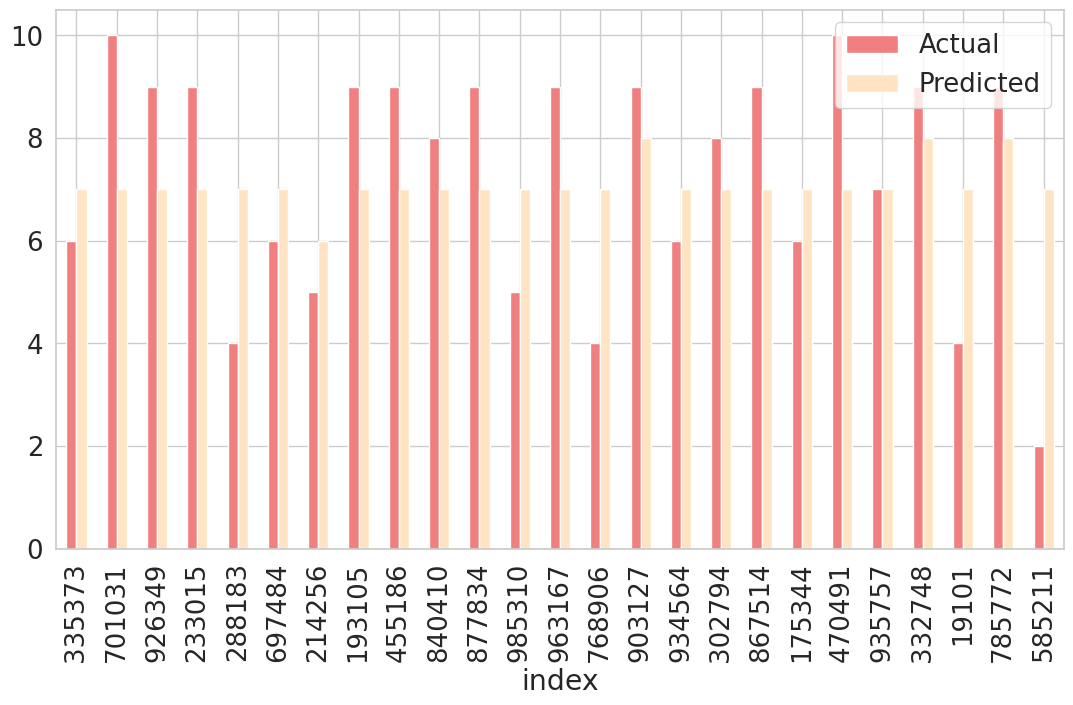

In [ ]:
predictions = xgb_model_nozero.predict(dtest_reg_nozero)
pred = pd.DataFrame({'Actual': y_test_nozero['Book-Rating'], 'Predicted': [int(a) for a in predictions.tolist()]}).head(25)
pred.plot(kind='bar', figsize=(13, 7), color=['lightcoral', 'bisque'])


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_nozero, predictions))
print('MSE:', metrics.mean_squared_error(y_test_nozero, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_nozero, predictions)))

MAE: 1.4557068405377427
MSE: 3.288501700011764
RMSE: 1.8134226479262257


Аналогично:

In [ ]:
methods = {
 'reg:linear': {"objective": 'reg:linear', "tree_method": "auto"},
 'reg:pseudohubererror': {"objective": 'reg:pseudohubererror', "tree_method": "auto"},
 'reg:absoluteerror':  {"objective": 'reg:absoluteerror', "tree_method": "auto"},
 'reg:quantileerror':  {"objective": 'reg:quantileerror', "tree_method": "auto", 'quantile_alpha': 0.95},
 'reg:gamma': {"objective": 'reg:gamma'},
 'reg:tweedie': {"objective": 'reg:tweedie'}}

best_xgb_model_nozero = None
best_xgb_model_nozero_mae = np.inf

for method in methods.keys():
    params = methods[method]
    n = 150

    t = time()

    xgb_model_nozero = xgb.train(
        params=params,
        dtrain=dtrain_reg_nozero,
        num_boost_round=n,
    )


    print('Time to fit the model: {} mins'.format(round((time() - t) / 60, 2)))

    predictions = xgb_model_nozero.predict(dtest_reg_nozero)
    mae = metrics.mean_absolute_error(y_test_nozero, predictions)

    print(f'method: {method}, scores:')
    print('MAE:', mae)
    print('MSE:', metrics.mean_squared_error(y_test_nozero, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_nozero, predictions)))
    print('\n')

    if mae < best_xgb_model_nozero_mae:
        best_xgb_model_nozero = xgb_model_nozero

Time to fit the model: 0.19 mins
method: reg:linear, scores:
MAE: 1.455011718016672
MSE: 3.2905270301764755
RMSE: 1.8139809894749381


Time to fit the model: 0.12 mins
method: reg:pseudohubererror, scores:
MAE: 181.62838496699808
MSE: 32992.28370255305
RMSE: 181.63778159444982


Time to fit the model: 0.41 mins
method: reg:absoluteerror, scores:
MAE: 1.4283139071106818
MSE: 3.4773293350677257
RMSE: 1.8647598598928832


Time to fit the model: 0.3 mins
method: reg:quantileerror, scores:
MAE: 2.3693670226621517
MSE: 9.027376921073197
RMSE: 3.004559355558348


Time to fit the model: 0.27 mins
method: reg:gamma, scores:
MAE: 1.4562108013849762
MSE: 3.294347840587409
RMSE: 1.815033840066738


Time to fit the model: 0.1 mins
method: reg:tweedie, scores:
MAE: 1.4574811717624867
MSE: 3.301840310328778
RMSE: 1.8170966706063765




# Нейронка

## Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
import torchvision

from typing import List, Callable
import itertools

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, leaky_coef=0.1):
        super(SimpleNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(leaky_coef)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(leaky_coef)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [ ]:
X_train

,Year-Of-Publication,Age,countries,mean_age,country_lvl
index,,,,,
676671,2000,36.558352,usa,36.917013,5
819812,1980,34.000000,usa,37.373536,5
365902,2000,32.000000,canada,37.624078,4
1899,2000,36.558352,usa,39.992959,5
604420,1980,27.000000,usa,27.000000,5
...,...,...,...,...,...
298531,2000,37.000000,argentina,37.000000,2
587562,1980,26.000000,usa,26.000000,5
954892,1980,30.000000,usa,34.205835,5


In [ ]:
num_classes = 10
model = SimpleNN(4, num_classes, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)

In [ ]:
batch_size = 16

y_tr = torch.tensor(y_train.values.astype(np.float32))
x_tr = torch.tensor(X_train.drop(['countries'], axis=1).values.astype(np.float32))
print(y_tr.shape, x_tr.shape)
train_ds = data_utils.TensorDataset(x_tr, y_tr)
train_dl = data_utils.DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True)

torch.Size([307069, 1]) torch.Size([307069, 4])


In [ ]:
y_ts = torch.tensor(y_test.values.astype(np.float32))
x_ts = torch.tensor(X_test.drop(['countries'], axis=1).values.astype(np.float32))
test_ds = data_utils.TensorDataset(x_tr, y_tr)
test_dl = data_utils.DataLoader(dataset = test_ds, batch_size = batch_size, shuffle = True)

In [ ]:
data = torch.stack([test_ds[i][0] for i in range(400)])
data_cls = np.array([test_ds[i][1] for i in range(400)])


n_epochs = 15
loss_fn = nn.MSELoss()
for epoch in list(range(n_epochs)):
    for imgs, lbls in train_dl:
        optimizer.zero_grad()
        out = model(imgs)
        loss = loss_fn(out, lbls)
        loss.backward()
        optimizer.step()
    test_acc = np.mean([int((i==j)*1) for i,j in zip(model(x_ts).argmax(dim=1), y_ts)])
    print("Epoch {} | loss: {} | acc: {}".format(epoch, loss.item(), test_acc))

Epoch 0 | loss: 4.579689979553223 | acc: 0.12029595279344527
Epoch 1 | loss: 1.8361799716949463 | acc: 0.12060857898370436
Epoch 2 | loss: 1.6907700300216675 | acc: 0.23743959150177807
Epoch 3 | loss: 2.1930930614471436 | acc: 0.13263166121741848
Epoch 4 | loss: 5.3001909255981445 | acc: 0.12792924227227137
Epoch 5 | loss: 1.7230143547058105 | acc: 0.12795529445479295
Epoch 6 | loss: 2.684447765350342 | acc: 0.2381560265211218
Epoch 7 | loss: 3.4548118114471436 | acc: 0.23224218108872072
Epoch 8 | loss: 2.3279385566711426 | acc: 0.19709778686709478
Epoch 9 | loss: 2.928698778152466 | acc: 0.19115788925217211
Epoch 10 | loss: 0.5211179852485657 | acc: 0.22051869895400486
Epoch 11 | loss: 3.5249392986297607 | acc: 0.1782490328127239
Epoch 12 | loss: 2.9016854763031006 | acc: 0.20394951087027316
Epoch 13 | loss: 2.7642290592193604 | acc: 0.12094725735648504
Epoch 14 | loss: 4.070569038391113 | acc: 0.2378434003308627
Epoch 15 | loss: 3.2070343494415283 | acc: 0.17525303182274096
Epoch 16 

In [209]:
p = model(x_ts)

<function Tensor.values>

<Axes: >

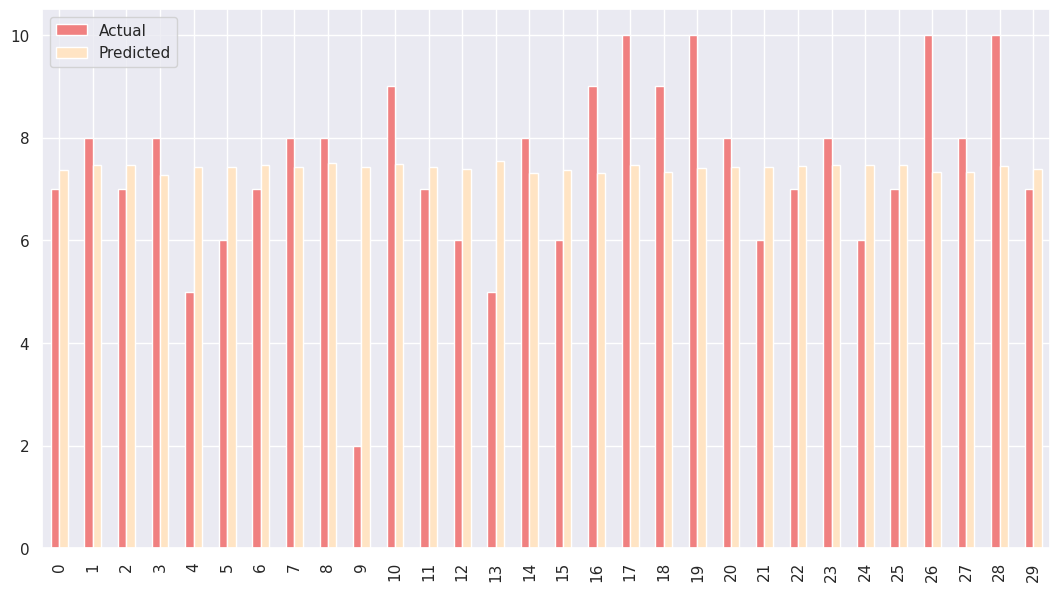

In [231]:
predictions = model(x_ts)
pred = pd.DataFrame({'Actual': [int(b) for b in y_ts], 'Predicted': [float(a.mean()) for a in predictions]}).head(30)
pred.plot(kind='bar', figsize=(13, 7), color=['lightcoral', 'bisque'])

## Tensorflow Keras

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def train_nn(X_train, y_train, X_test, y_test):
    nn_model = Sequential(
        [
            InputLayer(input_shape=X_train.shape[1:]),
            Dense(128, activation='relu', kernel_regularizer='l1'),
            Dense(512, activation='relu', kernel_regularizer='l1'),
            Dense(128, activation='relu', kernel_regularizer='l1'),
            Dropout(0.5),
            Dense(32, activation='relu', kernel_regularizer='l1'),
            Dense(1, activation='sigmoid')
        ]
    )
    nn_model.compile(
        optimizer=Adam(0.01),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    nn_model.build()
    print(nn_model.summary())

    nn_model.fit(X_train, y_train / 10, epochs=2, batch_size=1024)

    predictions = nn_model.predict(X_test, batch_size=1024) * 10
    pred = pd.DataFrame({'Actual': y_test['Book-Rating'], 'Predicted': [round(a[0]) for a in predictions.tolist()]}).head(25)
    pred.plot(kind='bar', figsize=(13, 7), color=['lightcoral', 'bisque'])

    print('Test MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('Test MSE:', metrics.mean_squared_error(y_test, predictions))
    print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

    return nn_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6912      
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 142,785
Trainable params: 142,785
Non-trai

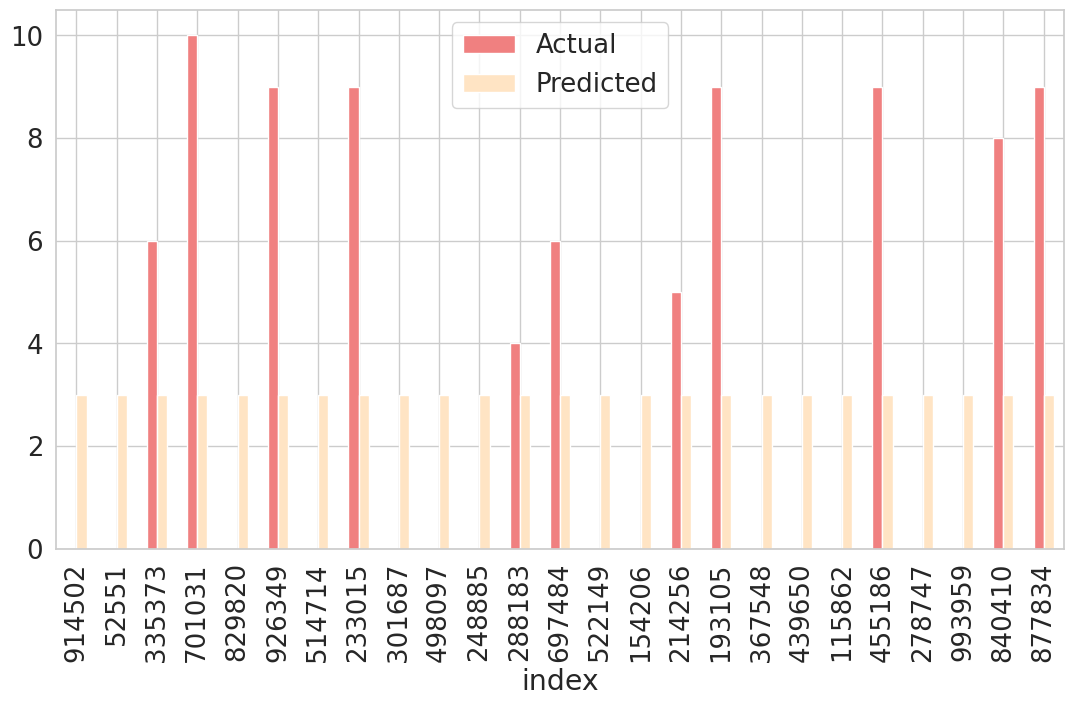

In [ ]:
nn_model = train_nn(X_train_transformed.toarray(), y_train, X_test_transformed.toarray(), y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               6912      
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 142,785
Trainable params: 142,785
Non-tr

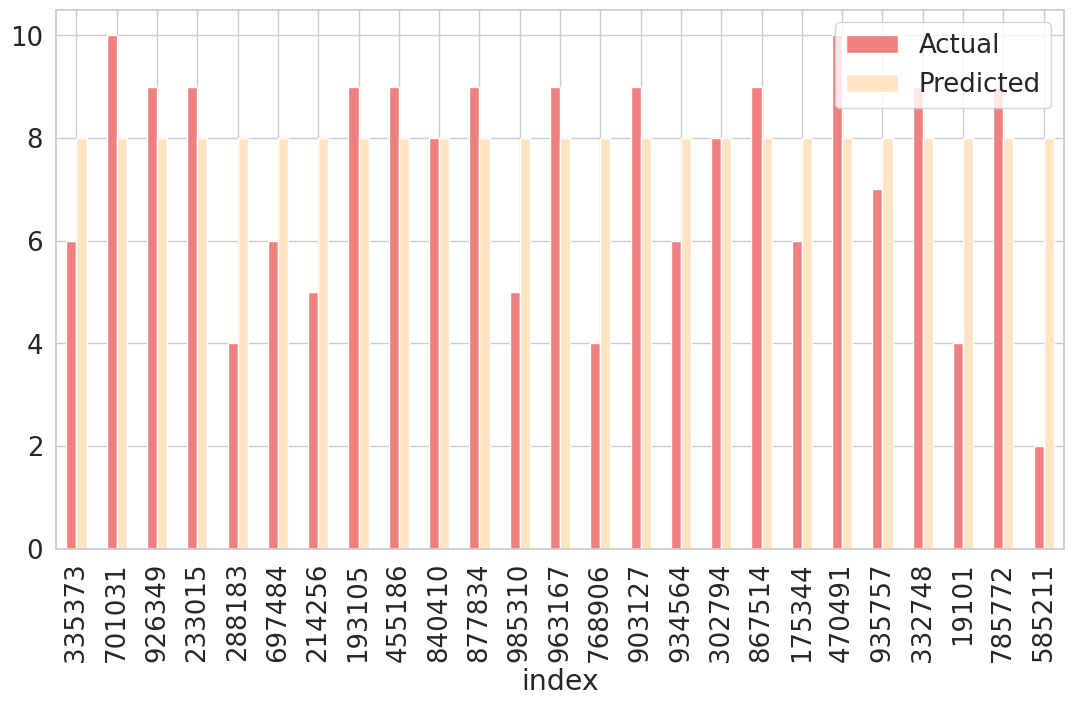

In [ ]:
nn_model_nozero = train_nn(X_train_nozero.toarray(), y_train_nozero, X_test_nozero.toarray(), y_test_nozero)

# Сравнение моделей

## Библиотека pyspark

In [ ]:
%%capture
!pip install pyspark

In [ ]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local')
spark = SparkSession(sc)

In [ ]:
ratings = books[['User-ID', 'ISBN', 'Book-Rating']]

In [ ]:
rating_non_zero = ratings[ratings["Book-Rating"] > 0]
rating_non_zero.shape

(383842, 3)

In [ ]:
def train_als(data):
    ratings_spark = spark.createDataFrame(ratings)

    data_spark = (ratings_spark
        .select(
            'User-ID',
            'ISBN',
            'Book-Rating',
        )
    ).cache()
    (training, test) = data_spark.randomSplit([0.8, 0.2])
    als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
    model = als.fit(training)

    predictions = model.transform(test)

    evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                    predictionCol="prediction")

    rmse = evaluator.evaluate(predictions)

    print("Root-mean-square error = " + str(rmse))

    evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                    predictionCol="prediction")

    mae = evaluator.evaluate(predictions)

    print("MAE = " + str(mae))

    return model

In [ ]:
%%time
als_model = train_als(ratings)

Root-mean-square error = 4.6483978961043
MAE = 2.685297748678936
CPU times: user 35.4 s, sys: 274 ms, total: 35.7 s
Wall time: 1min 41s


In [ ]:
%%time
als_non_zero = train_als(rating_non_zero)

Root-mean-square error = 4.6571962985609465
MAE = 2.6946859806611876
CPU times: user 34.5 s, sys: 186 ms, total: 34.7 s
Wall time: 1min 16s


## Библиотека surprise


In [ ]:
%%capture
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

In [ ]:
svd = SVD()
reader = Reader(rating_scale=(0, 11))
data = Dataset.load_from_df(ratings[["User-ID", "ISBN", "Book-Rating"]], reader)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5036  3.5013  3.5141  3.5141  3.5050  3.5076  0.0054  
MAE (testset)     2.8072  2.8068  2.8159  2.8118  2.8053  2.8094  0.0039  
Fit time          32.43   30.48   31.23   32.20   33.09   31.88   0.92    
Test time         3.20    2.07    4.40    3.66    1.83    3.03    0.97    


{'test_rmse': array([3.50363598, 3.50133166, 3.51411493, 3.51408463, 3.50495252]),
 'test_mae': array([2.80715312, 2.80676858, 2.81594384, 2.81176546, 2.80527167]),
 'fit_time': (32.429020404815674,
  30.477115392684937,
  31.228304147720337,
  32.19815540313721,
  33.0890474319458),
 'test_time': (3.197108745574951,
  2.0695912837982178,
  4.395397424697876,
  3.662665843963623,
  1.8286662101745605)}

In [ ]:
svd_non_zero = SVD()
reader = Reader(rating_scale=(0, 11))
data = Dataset.load_from_df(rating_non_zero[["User-ID", "ISBN", "Book-Rating"]], reader)

cross_validate(svd_non_zero, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6434  1.6399  1.6377  1.6338  1.6309  1.6371  0.0044  
MAE (testset)     1.2694  1.2660  1.2655  1.2608  1.2579  1.2640  0.0041  
Fit time          12.90   19.29   18.52   20.91   15.78   17.48   2.83    
Test time         2.46    0.62    0.99    2.31    0.61    1.40    0.82    


{'test_rmse': array([1.6433662 , 1.63987731, 1.63768259, 1.63379251, 1.6308767 ]),
 'test_mae': array([1.2694252 , 1.26603853, 1.26553536, 1.26082078, 1.25793371]),
 'fit_time': (12.896913528442383,
  19.29203748703003,
  18.524791955947876,
  20.90720224380493,
  15.784388065338135),
 'test_time': (2.4642081260681152,
  0.6189706325531006,
  0.9928669929504395,
  2.3110008239746094,
  0.6061584949493408)}

## Выберем юзеров и подготовим данные

Выберем 5 юзеров и выделим подготовленные данные по этим юзерам

In [ ]:
NUM_USERS = 5

rand_users = users.sample(NUM_USERS)

rand_users.head()

,User-ID,Location,Age
261684,261685,"bethpage, new york, usa",43.0
116631,116632,"london, n/a, united kingdom",29.0
232807,232808,"mohon, bretagne, france",33.0
73322,73323,"bismarck, illinois, usa",41.0
219006,219007,"london, ontario, canada",36.0


In [ ]:
res_train = df_train[df_train['User-ID'].isin(rand_users['User-ID'])]
res_test = df_test[df_test['User-ID'].isin(rand_users['User-ID'])]

print(res_train['User-ID'].value_counts())
print(res_test['User-ID'].value_counts())

261685    34
Name: User-ID, dtype: int64
261685    16
Name: User-ID, dtype: int64


In [ ]:
train_inds = [df_train.index.get_loc(ind) for ind in res_train.index]
test_inds = [df_test.index.get_loc(ind) for ind in res_test.index]

In [ ]:
rand_users_x_train = X_train_transformed[train_inds].toarray()
rand_users_y_train = y_train.iloc[train_inds].to_numpy()
rand_users_x_test = X_test_transformed[test_inds].toarray()
rand_users_y_test = y_test.iloc[test_inds].to_numpy()

print("Train features shape:", rand_users_x_train.shape)
print("Test features shape:", rand_users_x_test.shape)

Train features shape: (34, 53)
Test features shape: (16, 53)


In [ ]:
# Join

rand_users_features = np.concatenate([rand_users_x_train, rand_users_x_test])
rand_users_labels = np.concatenate([rand_users_y_train, rand_users_y_test])

print("Features shape:", rand_users_features.shape)
print("Labels shape:", rand_users_labels.shape)

Features shape: (50, 53)
Labels shape: (50, 1)


Выделим данные по юзерам для моделей коллаборативной фильтрации

In [ ]:
rand_users_ratings = ratings[ratings['User-ID'].isin(rand_users['User-ID'])]

print("Num users:", rand_users_ratings.shape)

rand_users_ratings.head()

Num users: (50, 3)


,User-ID,ISBN,Book-Rating
606051,261685,99240,0
606052,261685,132855,0
606053,261685,186914,0
606054,261685,121902,9
606055,261685,185090,0


## Cделаем предсказания (с нулями)

In [ ]:
# модели коллаборативной фильтрации

rand_users_ratings_spark = (
    spark.createDataFrame(rand_users_ratings)
    .select(
        'User-ID',
        'ISBN'
    )
).cache()
als_predict = als_model.transform(rand_users_ratings_spark).toPandas()
als_predict = als_predict.rename(columns={"prediction": "ALS"})

In [ ]:
rand_users_ratings_testset = Dataset \
    .load_from_df(rand_users_ratings, reader) \
    .build_full_trainset().build_testset()

svd_predict = rand_users_ratings[['User-ID', 'ISBN']].copy()
svd_predict['SVD'] = [i.est for i in svd.test(rand_users_ratings_testset)]

In [ ]:
# предсказания наших моделей

lr_predict = lr.predict(rand_users_features)
rfc_predict = rfc.predict(rand_users_features)
xgb_predict = xgb_model.predict(xgb.DMatrix(rand_users_features, rand_users_labels))
nn_predict = nn_model.predict(rand_users_features)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.0s finished


2/2 [==============================] - 0s 11ms/step


In [ ]:
res_df = res_train[['User-ID', 'ISBN', 'Book-Rating']].append(res_test[['User-ID', 'ISBN', 'Book-Rating']])
res_df['Linear'] = lr_predict
res_df['Random Forest'] = rfc_predict
res_df['XGBOOST'] = xgb_predict
res_df['Neural Network'] = nn_predict

In [ ]:
res_df = res_df.merge(als_predict, on=['User-ID', 'ISBN'])
res_df = res_df.merge(svd_predict, on=['User-ID', 'ISBN'])

In [ ]:
res_df['Mean'] = (res_df['Linear'] + res_df['Random Forest'] + \
                 res_df['XGBOOST'] + res_df['Neural Network'] + \
                 res_df['ALS'] + res_df['SVD']) / 6

In [ ]:
res_df

,User-ID,ISBN,Book-Rating,Linear,Random Forest,XGBOOST,Neural Network,ALS,SVD,Mean
0,261685,141494,0,2.579799,0,0.000244,0.292501,0.000001,1.019390,0.648656
1,261685,231922,10,2.955745,0,0.000126,0.292501,0.000447,6.427761,1.612763
2,261685,218116,0,2.631100,0,0.000504,0.292501,0.000010,0.717423,0.606923
3,261685,132683,0,2.599537,0,0.000027,0.292501,0.002502,0.000000,0.482428
4,261685,127365,0,2.761329,0,0.000004,0.292501,-0.000039,0.163610,0.536234
5,261685,5548,0,2.933828,0,0.000694,0.292501,0.000028,0.228263,0.575886
6,261685,136203,0,2.623670,0,0.000534,0.292501,0.002522,0.000000,0.486538
7,261685,87005,0,2.536611,0,0.000030,0.292501,0.000684,0.764561,0.599064
8,261685,152073,0,2.530069,0,0.000039,0.292501,0.000000,0.811789,0.605733
9,261685,223289,0,2.883942,0,0.000029,0.292501,0.000000,1.481243,0.776286


## Cделаем предсказания (без нулей)

Выберем данные без нулей

In [ ]:
train_nozero_inds = [X_train_nozero_df.index.get_loc(ind) for ind in res_train[res_train["Book-Rating"] > 0].index]
test_nozero_inds = [X_test_nozero_df.index.get_loc(ind) for ind in res_test[res_test["Book-Rating"] > 0].index]

In [ ]:
rand_users_x_train_nozero = X_train_nozero[train_nozero_inds].toarray()
rand_users_y_train_nozero = y_train_nozero.iloc[train_nozero_inds].to_numpy()
rand_users_x_test_nozero = X_test_nozero[test_nozero_inds].toarray()
rand_users_y_test_nozero = y_test_nozero.iloc[test_nozero_inds].to_numpy()

print("Train features shape:", rand_users_x_train_nozero.shape)
print("Test features shape:", rand_users_x_test_nozero.shape)

Train features shape: (7, 53)
Test features shape: (1, 53)


In [ ]:
rand_users_features_nozero = np.concatenate([rand_users_x_train_nozero, rand_users_x_test_nozero])
rand_users_labels_nozero = np.concatenate([rand_users_y_train_nozero, rand_users_y_test_nozero])

print("Features shape:", rand_users_features_nozero.shape)
print("Labels shape:", rand_users_labels_nozero.shape)

Features shape: (8, 53)
Labels shape: (8, 1)


In [ ]:
rand_users_ratings_nozero = rand_users_ratings[rand_users_ratings['Book-Rating'] > 0]

print("Num users:", rand_users_ratings_nozero.shape)

rand_users_ratings_nozero.head()

Num users: (8, 3)


,User-ID,ISBN,Book-Rating
606054,261685,121902,9
606059,261685,108677,8
606063,261685,170030,6
606071,261685,7835,10
606072,261685,152327,8


Получим предсказания

In [ ]:
# модели коллаборативной фильтрации

rand_users_ratings_nozero_spark = (
    spark.createDataFrame(rand_users_ratings_nozero)
    .select(
        'User-ID',
        'ISBN'
    )
).cache()
als_predict = als_non_zero.transform(rand_users_ratings_nozero_spark).toPandas()
als_predict = als_predict.rename(columns={"prediction": "ALS"})

In [ ]:
rand_users_ratings_nozero_testset = Dataset \
    .load_from_df(rand_users_ratings_nozero, reader) \
    .build_full_trainset().build_testset()

svd_predict = rand_users_ratings_nozero[['User-ID', 'ISBN']].copy()
svd_predict['SVD'] = [i.est for i in svd_non_zero.test(rand_users_ratings_nozero_testset)]

In [ ]:
# предсказания наших моделей

lr_predict = lr_nozero.predict(rand_users_features_nozero)
rfc_predict = rfc_nozero.predict(rand_users_features_nozero)
xgb_predict = xgb_model_nozero.predict(xgb.DMatrix(rand_users_features_nozero, rand_users_labels_nozero))
nn_predict = nn_model_nozero.predict(rand_users_features_nozero)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.0s finished


1/1 [==============================] - 0s 63ms/step


In [ ]:
res_df = res_train[['User-ID', 'ISBN', 'Book-Rating']].append(res_test[['User-ID', 'ISBN', 'Book-Rating']])
res_df = res_df[res_df['Book-Rating'] > 0]

res_df['Linear'] = lr_predict
res_df['Random Forest'] = rfc_predict
res_df['XGBOOST'] = xgb_predict
res_df['Neural Network'] = nn_predict

In [ ]:
res_df = res_df.merge(als_predict, on=['User-ID', 'ISBN'])
res_df = res_df.merge(svd_predict, on=['User-ID', 'ISBN'])

In [ ]:
res_df['Mean'] = (res_df['Linear'] + res_df['Random Forest'] + \
                 res_df['XGBOOST'] + res_df['Neural Network'] + \
                 res_df['ALS'] + res_df['SVD']) / 6

In [ ]:
res_df

,User-ID,ISBN,Book-Rating,Linear,Random Forest,XGBOOST,Neural Network,ALS,SVD,Mean
0,261685,231922,10,7.708203,7,2.678693,0.762026,0.000665,8.680643,4.471705
1,261685,121902,9,7.712264,9,9.418944,0.762026,0.005446,8.196523,5.849201
2,261685,85492,7,7.648899,7,3.074222,0.762026,0.001286,7.431385,4.319636
3,261685,152327,8,7.651489,8,9.695388,0.762026,0.001404,8.404003,5.752385
4,261685,108677,8,7.707789,8,3.433106,0.762026,0.003880,8.261816,4.694769
5,261685,133121,10,7.653664,10,6.016901,0.762026,0.001063,8.511683,5.490889
6,261685,7835,10,7.654705,10,4.692124,0.762026,0.000665,8.628688,5.289701
7,261685,170030,6,7.709484,10,2.926907,0.762026,0.000501,6.940556,4.723246
